This notebook has been prepared to show a basic workflow for DEA uses

# 1. Import libraries

## python libraries

In [1]:
import datacube
from datacube.utils import geometry
from datacube.storage import masking


import xarray as xr
import pandas as pd
import fiona

%matplotlib inline

## DEA scripts

In [18]:
# Import the custom script from the dea-notebooks repository.
import sys
import os.path
sys.path.append(os.path.expanduser('10_Scripts'))
import DEAPlotting
import DEADataHandling

# 2. Link to Datacube

In [19]:
dc = datacube.Datacube()

In [20]:
dc.list_products()

,name,description,lon,gsi,gqa_iterative_mean_xy,gqa_iterative_stddev_xy,sat_row,creation_time,lat,platform,...,gqa_cep90,gqa,orbit,instrument,gqa_ref_source,time,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,,,,,,,
36,bom_rainfall_grids,Interpolated Rain Gauge Precipitation 1-Day Au...,NaN,NaN,NaN,NaN,NaN,None,NaN,BoM,...,NaN,NaN,NaN,rain gauge,NaN,None,EPSG:4326,"(-0.05, 0.05)",None,"(latitude, longitude)"
88,dsm,"dsm ancillary data for wofs confidence, 25 met...",NaN,NaN,NaN,NaN,NaN,None,NaN,None,...,NaN,NaN,NaN,None,NaN,None,EPSG:3577,"(-25, 25)","(100000.0, 100000.0)","(y, x)"
32,dsm1sv10,DSM 1sec Version 1.0,NaN,NaN,NaN,NaN,NaN,None,NaN,SRTM,...,NaN,NaN,NaN,SIR,NaN,None,EPSG:4326,"(-0.00027777777778, 0.00027777777778)",None,"(latitude, longitude)"
99,fc_percentile_albers_annual,"Landsat Fractional Cover percentile 25 metre, ...",NaN,NaN,NaN,NaN,NaN,None,NaN,"LANDSAT_5,LANDSAT_7,LANDSAT_8",...,NaN,NaN,NaN,"TM,ETM+,OLI",NaN,None,EPSG:3577,"(-25, 25)","(100000.0, 100000.0)","(y, x)"
53,gamma_ray,The 2015 radiometric or gamma-ray grid of Aust...,NaN,NaN,NaN,NaN,NaN,None,NaN,aircraft,...,NaN,NaN,NaN,gamma_ray spectrometer,NaN,None,"GEOGCS[""GEOCENTRIC DATUM of AUSTRALIA"",DATUM[""...","(-0.001, 0.001)",None,"(latitude, longitude)"
63,high_tide_comp_20p,High Tide 20 percentage composites for entire ...,NaN,NaN,NaN,NaN,NaN,None,NaN,None,...,NaN,NaN,NaN,None,NaN,None,EPSG:3577,"(-25, 25)",None,"(y, x)"
64,high_tide_comp_count,High Tide 20 percentage pixel count,NaN,NaN,NaN,NaN,NaN,None,NaN,None,...,NaN,NaN,NaN,None,NaN,None,EPSG:3577,"(-25, 25)",None,"(y, x)"
67,item_v2,Intertidal Extents Model,NaN,NaN,NaN,NaN,NaN,None,NaN,None,...,NaN,NaN,NaN,None,NaN,None,EPSG:3577,"(-25, 25)",None,"(y, x)"
68,item_v2_conf,Average ndwi Standard Deviation,NaN,NaN,NaN,NaN,NaN,None,NaN,None,...,NaN,NaN,NaN,None,NaN,None,EPSG:3577,"(-25, 25)",None,"(y, x)"


# 3. Create query

In [21]:
# Define temporal and spatial extents to pass to `dc.load` for the data extraction:
query = {'lat': (-35.25, -35.35),
         'lon': (149.05, 149.17),
         'time':('2017-01-01', '2017-06-30')}

or

In [25]:
# # Set this to the location you have saved your ACT boundary polygon
shape_file = os.path.expanduser('Supplementary_data/Files/ACT_Reserves.shp')

#Import our shapefile with Fiona, and grab its geometry for the DEA extraction query
with fiona.open(shape_file) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

#create query        
query= {'geopolygon': geom,
         'time': ('2017-01-01', '2017-06-30')}

In [26]:
query

{'geopolygon': Geometry(POLYGON ((680327.1464 6051279.0748,680355.0012 6051208.2515,680431.7446 6051238.7655,680505.1296 6051235.8891,680543.1007 6051245.9836,680545.4287 6051246.6061,680544.968 6051244.3753,680544.3885 6051242.4469,680587.6125 6051207.6735,680569.4455 6051210.8605,680569.3776 6051206.8064,680574.1496 6051166.0538,680583.817 6051138.4928,680592.3219 6051113.9908,680606.1954 6051080.838,680614.7759 6051053.4342,680619.797 6051025.103,680625.8226 6050934.8988,680627.2547 6050894.9046,680627.398 6050887.2457,680629.7987 6050825.6691,680584.7756 6050795.9665,680501.2882 6050802.2101,680432.6634 6050800.4236,680344.8519 6051157.0129,680234.9387 6051245.0167,680234.9375 6051323.6712,680302.1691 6051354.6447,680309.6474 6051433.2313,680313.1282 6051401.2262,680327.1464 6051279.0748)), PROJCS["GDA94 / MGA zone 55",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG"

# 4. Load datacube data

In [28]:
help(DEADataHandling.load_clearlandsat)

Help on function load_clearlandsat in module DEADataHandling:

load_clearlandsat(dc, query, sensors=('ls5', 'ls7', 'ls8'), product='nbart', bands_of_interest=None, masked_prop=0.0, mask_dict=None, mask_pixel_quality=True, mask_invalid_data=True, ls7_slc_off=False, satellite_metadata=False)
    Loads Landsat NBAR, NBART or FC25 and PQ data for multiple sensors (i.e. ls5, ls7, ls8) and returns a single 
    xarray dataset containing only observations that contain greater than a given proportion of good quality pixels.
    
    This function can be used to extract visually appealing time series of observations that are not affected by cloud,
    for example as an input to the `animated_timeseries` function from `DEAPlotting`.
    
    The proportion of clear pixels is calculated by summing the pixels that are marked as being good quality
    in the Landsat PQ25 layer. By default cloud, cloud shadow, saturated pixels and pixels missing data for any band 
    are considered poor quality dat

In [29]:
ds = DEADataHandling.load_clearlandsat(dc=dc, query=query, sensors=('ls5', 'ls7', 'ls8'),
                                       product='nbart', mask_pixel_quality=False, mask_invalid_data=True,
#                                        bands_of_interest=['red', 'green', 'blue', 'nir', 'swir1'], 
                                       masked_prop=0.90)  

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 13 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [30]:
ds

<xarray.Dataset>
Dimensions:          (time: 13, x: 16, y: 28)
Coordinates:
  * time             (time) datetime64[ns] 2017-01-14T23:57:02 ... 2017-06-23T23:56:37
  * y                (y) float64 -3.998e+06 -3.998e+06 ... -3.999e+06 -3.999e+06
  * x                (x) float64 1.532e+06 1.532e+06 ... 1.533e+06 1.533e+06
Data variables:
    coastal_aerosol  (time, y, x) float64 338.0 301.0 288.0 ... 176.0 171.0
    blue             (time, y, x) float64 366.0 315.0 310.0 ... 141.0 148.0 95.0
    green            (time, y, x) float64 558.0 487.0 483.0 ... 250.0 149.0
    red              (time, y, x) float64 701.0 627.0 632.0 ... 290.0 226.0
    nir              (time, y, x) float64 1.994e+03 1.911e+03 ... 1.261e+03
    swir1            (time, y, x) float64 2.401e+03 2.139e+03 ... 1.13e+03 901.0
    swir2            (time, y, x) float64 1.519e+03 1.292e+03 ... 619.0 483.0
    data_perc        (time) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    crs:      EPSG:3577

Now... Let's try:

1) Masking cloud

2)  fractional cover

# 5. Basic plots

In [33]:
DEAPlotting.rgb

<function DEAPlotting.rgb(ds, bands=['red', 'green', 'blue'], index=None, index_dim='time', robust=True, percentile_stretch=None, col_wrap=4, size=6, aspect=1, savefig_path=None, savefig_kwargs={}, **kwargs)>

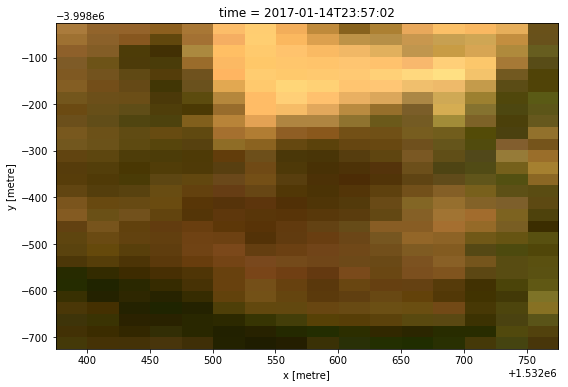

In [40]:
DEAPlotting.rgb(ds, bands=['red', 'green', 'blue'], index_dim = 'time', index=0,)
#DEAPlotting.rgb(ds, bands=['swir1',  'nir', 'green'], index_dim = 'time', index=0,)

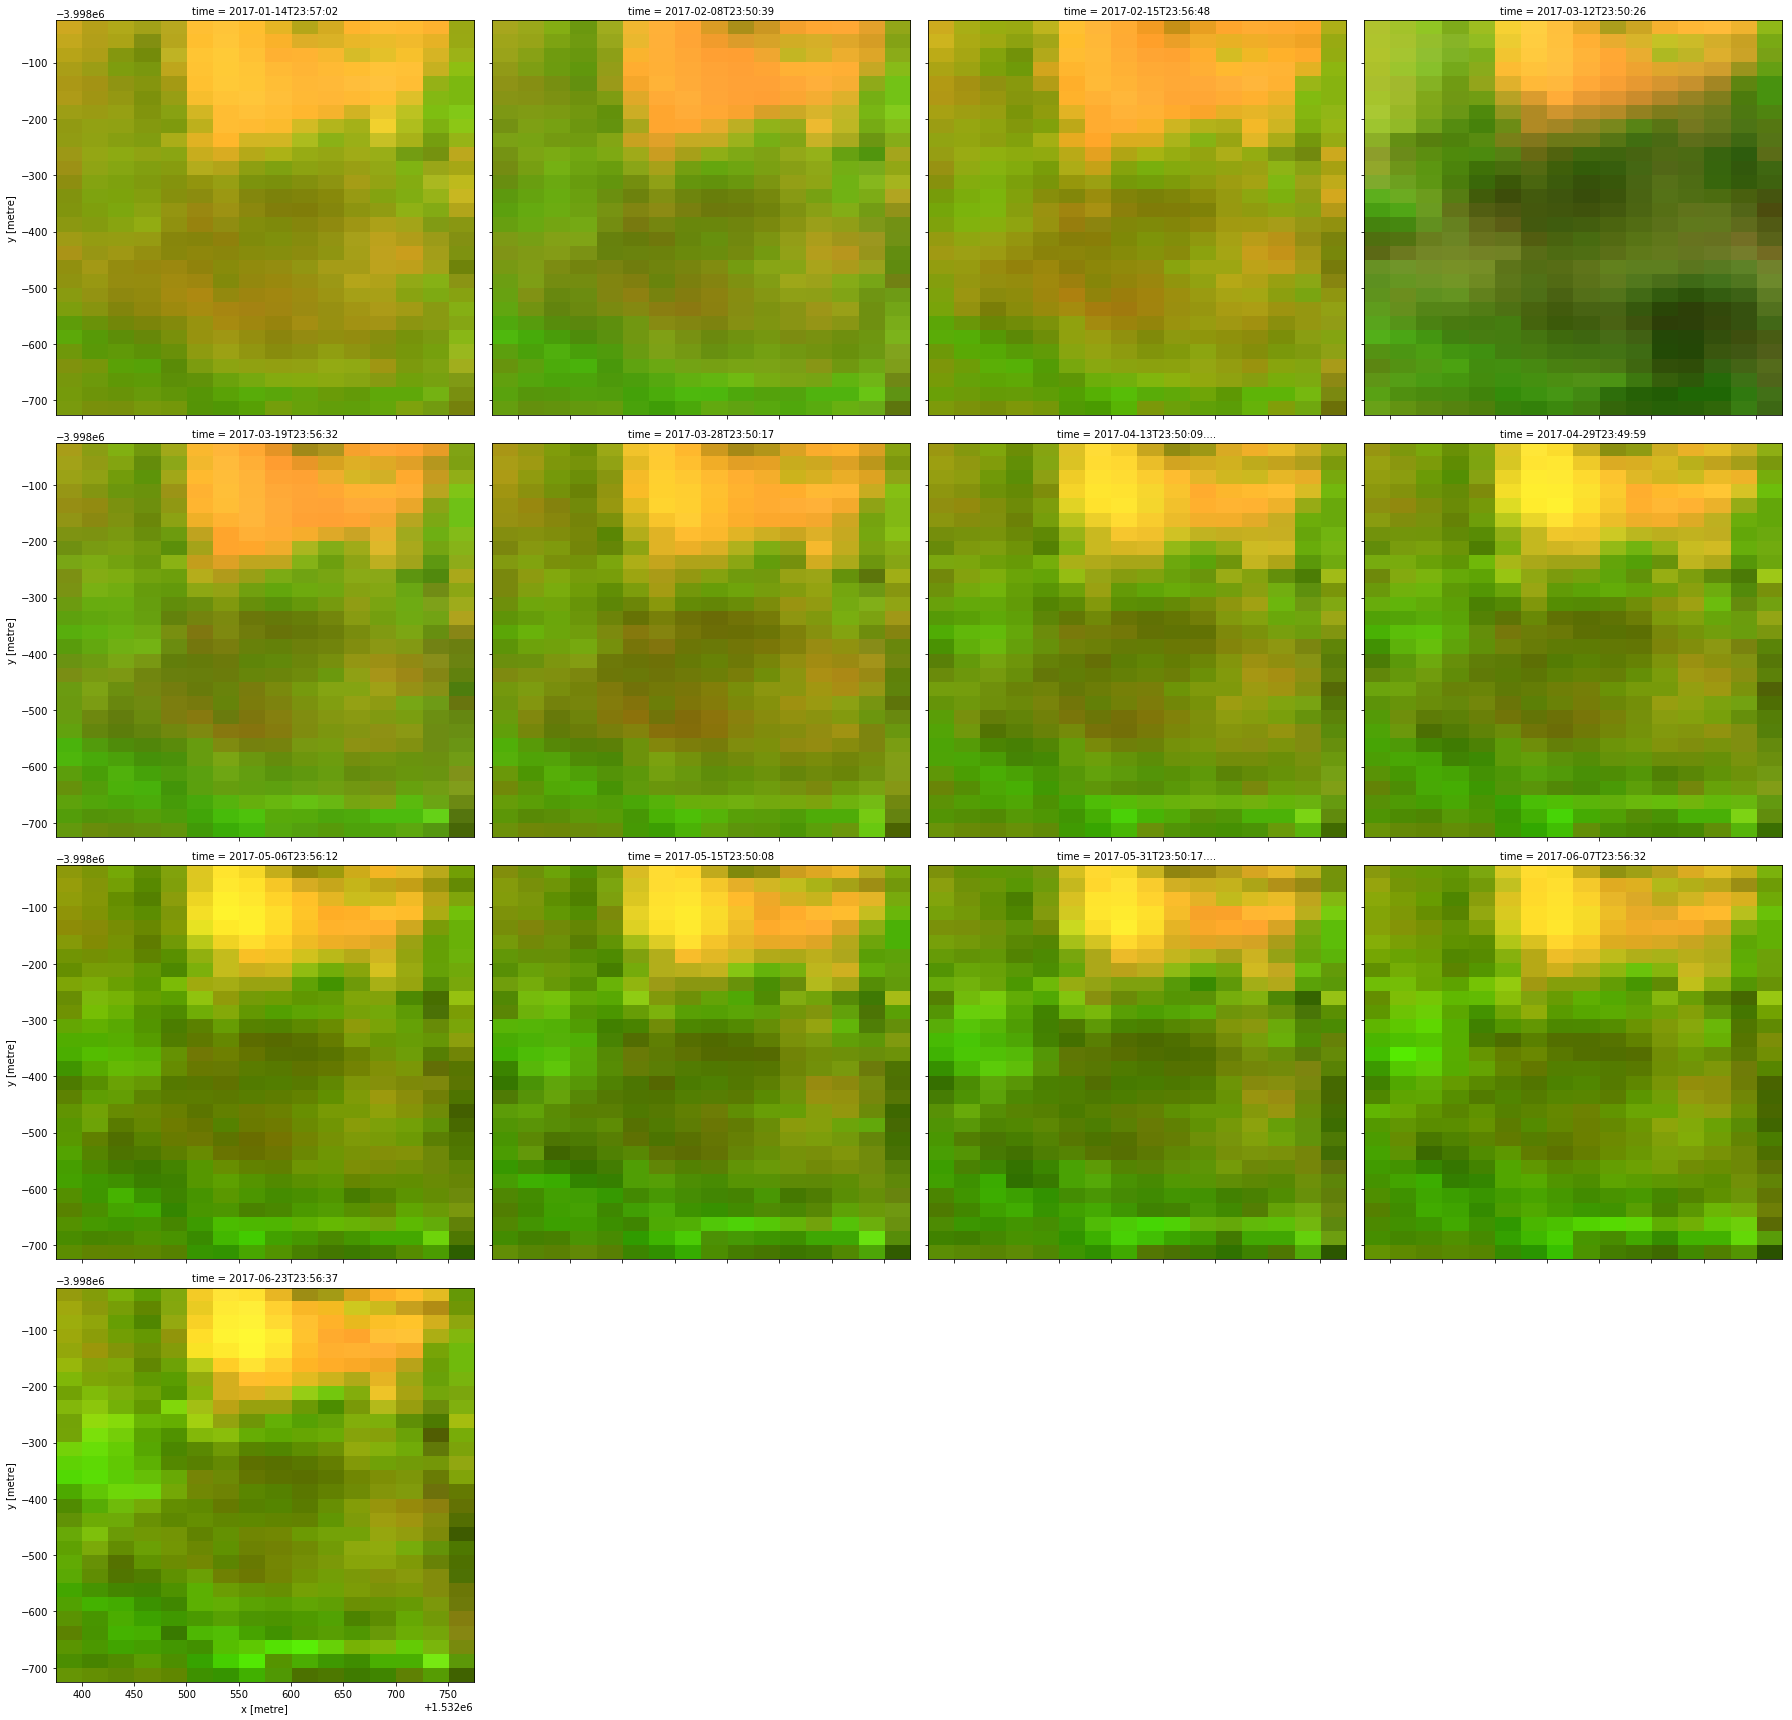

In [45]:
DEAPlotting.rgb(ds, bands=['swir1',  'nir', 'green'], index_dim = 'time',col="time", col_wrap=4)

In [51]:
# ds.red.isel(time=0).plot(figsize=(10, 10));

# 6. Index calculation

Bands from Landsat surface reflectance products can be combined to compute simple remote sensing indices that provide insights into different aspects of the observed landscape. For example, we can calculate the Normalized Difference Water Index (NDWI), which has high values where a pixel is likely to be open water (e.g. NDWI > 0, or red colours below):

In [46]:
# Compute NDWI using the formula (green - nir) / (green + nir). This will calculate
# NDWI for every time-step in the dataset:
ds_ndwi = (ds.green - ds.nir) / (ds.green + ds.nir)
ds_ndwi

<xarray.DataArray (time: 13, y: 28, x: 16)>
array([[[-0.562696, -0.593828, ..., -0.492888, -0.646186],
        [-0.58274 , -0.59815 , ..., -0.547365, -0.648026],
        ...,
        [-0.695133, -0.697719, ..., -0.677316, -0.637654],
        [-0.676511, -0.678349, ..., -0.651825, -0.641529]],

       [[-0.578905, -0.604167, ..., -0.482453, -0.615196],
        [-0.594957, -0.609053, ..., -0.507409, -0.630471],
        ...,
        [-0.691769, -0.687791, ..., -0.684287, -0.619654],
        [-0.667254, -0.662857, ..., -0.633414, -0.61016 ]],

       ...,

       [[-0.679452, -0.729038, ..., -0.627092, -0.719313],
        [-0.696235, -0.73051 , ..., -0.599258, -0.735499],
        ...,
        [-0.810924, -0.794536, ..., -0.790075, -0.712454],
        [-0.761787, -0.767368, ..., -0.764879, -0.83165 ]],

       [[-0.679928, -0.709324, ..., -0.585735, -0.736817],
        [-0.689582, -0.690323, ..., -0.594189, -0.738795],
        ...,
        [-0.767537, -0.776309, ..., -0.737949, -0.714687],


In [47]:
ds["NDWI"] = ds_ndwi
ds

<xarray.Dataset>
Dimensions:          (time: 13, x: 16, y: 28)
Coordinates:
  * time             (time) datetime64[ns] 2017-01-14T23:57:02 ... 2017-06-23T23:56:37
  * y                (y) float64 -3.998e+06 -3.998e+06 ... -3.999e+06 -3.999e+06
  * x                (x) float64 1.532e+06 1.532e+06 ... 1.533e+06 1.533e+06
Data variables:
    coastal_aerosol  (time, y, x) float64 338.0 301.0 288.0 ... 176.0 171.0
    blue             (time, y, x) float64 366.0 315.0 310.0 ... 141.0 148.0 95.0
    green            (time, y, x) float64 558.0 487.0 483.0 ... 250.0 149.0
    red              (time, y, x) float64 701.0 627.0 632.0 ... 290.0 226.0
    nir              (time, y, x) float64 1.994e+03 1.911e+03 ... 1.261e+03
    swir1            (time, y, x) float64 2.401e+03 2.139e+03 ... 1.13e+03 901.0
    swir2            (time, y, x) float64 1.519e+03 1.292e+03 ... 619.0 483.0
    data_perc        (time) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    NDWI             (time, y, x) float

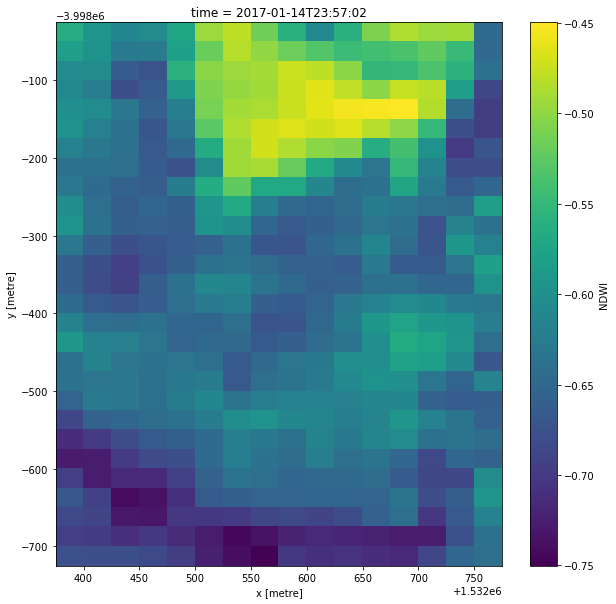

In [54]:
# First, we select the variable we want ('NDWI'), and then make a
# plot with one column for each time-step:
ndwi_image = ds.NDWI.isel(time=0).plot(figsize=(10, 10));

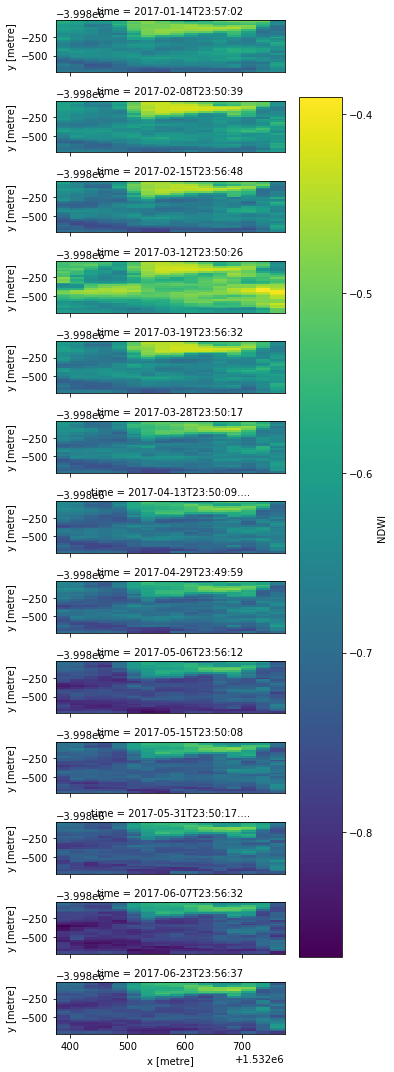

In [57]:
ds.NDWI.plot(row='time', figsize=(5, 15));

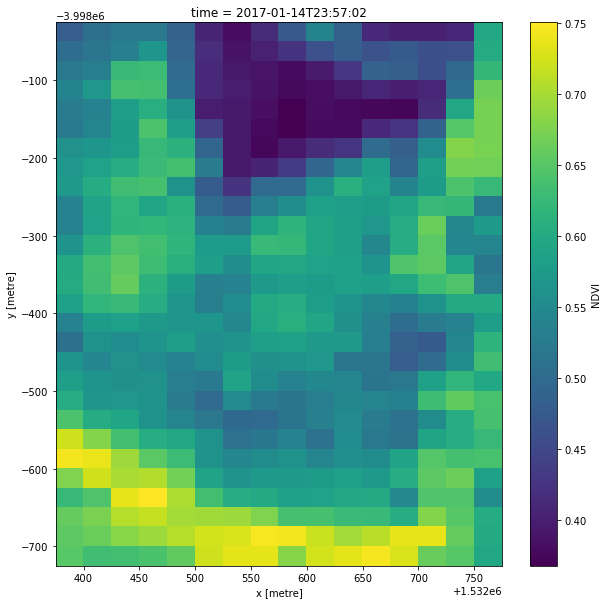

In [58]:
# Compute NDVI using the formula (nir - red) / (nir + red)
ds_ndvi = (ds.nir - ds.red) / (ds.nir + ds.red)

# Add this back into our dataset as a new data variable:
ds["NDVI"] = ds_ndvi

# Plot:
ds.NDVI.isel(time=0).plot(figsize=(10, 10));

In [59]:
ds_ndvi

<xarray.DataArray (time: 13, y: 28, x: 16)>
array([[[0.479777, 0.50591 , ..., 0.408252, 0.597439],
        [0.502443, 0.517159, ..., 0.46119 , 0.601278],
        ...,
        [0.655605, 0.662942, ..., 0.660735, 0.600555],
        [0.651007, 0.632882, ..., 0.649622, 0.595382]],

       [[0.50152 , 0.529412, ..., 0.400364, 0.582866],
        [0.516042, 0.53695 , ..., 0.439939, 0.595552],
        ...,
        [0.685129, 0.672979, ..., 0.685516, 0.599281],
        [0.656318, 0.627972, ..., 0.660346, 0.592572]],

       ...,

       [[0.612451, 0.665906, ..., 0.515399, 0.670775],
        [0.604585, 0.660203, ..., 0.512944, 0.67263 ],
        ...,
        [0.770021, 0.75803 , ..., 0.766115, 0.700773],
        [0.715805, 0.708037, ..., 0.72666 , 0.790947]],

       [[0.608658, 0.633188, ..., 0.485155, 0.694947],
        [0.605611, 0.617997, ..., 0.474642, 0.663439],
        ...,
        [0.739043, 0.728686, ..., 0.71301 , 0.687069],
        [0.705854, 0.687135, ..., 0.731233, 0.696032]]])
Coo